# Analysis Notebook for CurioTower experiment

(Need to add link to pre-registration)

The goal of this experiment is to gather human judgments on the "interestingness" and "stability" of towers, both generated in curiodrop and TDW

### Establish connection to mongo
First thing you need to do is to establish an ssh tunnel (aka remote port forwarding) to the server, so that requests to the mongodb can be made "as if" the mongodb server is running on your local computer. Run this from the command line before you begin data analysis if you plan to fetch data from mongo:

`ssh -fNL 27017:127.0.0.1:27017 USERNAME@cogtoolslab.org`

### Load packages

In [1]:
import os
import sys
import urllib, io
os.getcwd()
sys.path.append("..")
sys.path.append("../utils")
sys.path.append("../analysis/utils")


import numpy as np
import scipy.stats as stats
import pandas as pd

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
plt.style.use('seaborn-white')

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

# import drawing_utils as drawing
# import importlib
# import scoring

### Set up directory paths to plots and data

In [2]:
## directory & file hierarchy
proj_dir = os.path.abspath('..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir =  os.path.abspath('.')
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
json_dir = os.path.join(results_dir,'json')
exp_dir = os.path.abspath(os.path.join(proj_dir,'behavioral_experiments'))
png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       
    
## add helpers to python path
if os.path.join(proj_dir,'utils') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'utils'))   

def make_dir_if_not_exists(dir_name):   
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    return dir_name

## create directories that don't already exist        
result = [make_dir_if_not_exists(x) for x in [results_dir,plot_dir,csv_dir]]

In [3]:
# set vars 
auth = pd.read_csv(os.path.join(analysis_dir,'auth.txt'), header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'cogtoolslab.org'

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')


#### Connect to database

In [4]:
db = conn['curiotower']
coll = db['tdw-height3Jitter3']
print('Iterations List:', coll.distinct('iterationName'))

iterationName = 'run_0'

Iterations List: ['testing', 'run_0']


In [5]:
# how many records?
print('We have {} records in mongo.'.format(coll.estimated_document_count()))

We have 27491 records in mongo.


In [6]:
survey = coll.find({'iterationName':iterationName, 'eventType':'survey'})
df_survey = pd.DataFrame(survey)
df_survey.head(1)
# print(df_survey['responses'].unique())

,_id,workerId,hitID,aID,iterationName,eventType,rt,responses,question_order,trial_type,trial_index,time_elapsed,internal_node_id,gameID
0,5fffc66cf2e06b2b75acd987,,,,run_0,survey,6185.0,"{""participantSex"":""Male"",""technicalDifficultie...","[0,1]",survey-multi-choice,147,792652,0.0-147.0,NaN


### Construct tidy dataframe with game data

In [7]:
df = coll.find({
            'iterationName':iterationName
#             'prolificID': {'$exists' : True},
#             'studyID': {'$exists' : True},
#             'sessionID': {'$exists' : True},
#             'eventType': 'rating-task'
})
df = pd.DataFrame(df)
df['button_pressed'] = pd.to_numeric(df['button_pressed'])
print('unique Prolific IDs:', len(df['prolificID'].unique()))
print(df.shape)

df.head(2)

unique Prolific IDs: 186
(27342, 44)


,_id,type,iterationName,condition,prompt,towerID,image_url,num_blocks,stim_version,catch_trial,...,trial_index,time_elapsed,internal_node_id,workerId,hitID,aID,eventType,rt,responses,question_order
0,5fffc373f2e06b2b75acd795,image-button-response,run_0,interesting,How interesting is this?,curiotower_4_low_0001_0,https://curiotower-tdw.s3.amazonaws.com/curiot...,4.0,tdw-height3Jitter3,False,...,1,81855,0.0-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5fffc379f2e06b2b75acd796,image-button-response,run_0,interesting,How interesting is this?,curiotower_8_low_0000_1,https://curiotower-tdw.s3.amazonaws.com/curiot...,8.0,tdw-height3Jitter3,False,...,2,88133,0.0-2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Or read in most recent data directly from csv

In [8]:
#df = pd.read_csv('curiotower_raw_data_{}.csv'.format(iterationName))

## Include catch-trial checks:

1. Check whether subjects rated the catch trials as stable <3 or interesting >3. 
2. Check that subjects completed all trials

Remove those who fail either catch

In [9]:
df_catch = df[df['catch_trial'] == True]

#return array of gameIDs that failed catch trials
failed_attention_check = df_catch[((df_catch['button_pressed'] <3) & (df_catch['condition'] == 'stable')) |
                       ((df_catch['button_pressed'] >1) & (df_catch['condition'] == 'interesting'))]['prolificID'].unique()
failed_attention_check

array(['5f6a4e9f9b08d50eef23534d', '5f7e6f9c1212c514f9437e3a',
       '5f40d413c4c518219392e3ab', '5f44b9936976d47ffd423818',
       '5fccc52fba48b3afa2c27649'], dtype=object)

In [10]:
num_stims = 144
df = df[df.type == 'image-button-response']
df = df[~df['towerID'].str.contains("0999", na=False)]
df_response_count = df.groupby(['prolificID'])['button_pressed'].agg(['count']).reset_index()
failed_completion_check = df_response_count[df_response_count['count'] !=num_stims]['prolificID']
failed_completion_check

6      573c6b96b3a71f00146df8c4
32     5be742980bedce00010bcf31
58     5d844d920af9530001c58a35
100    5ec38c84db44d61e05e05048
108    5efdb59031628202f67defe6
111    5f062a29acc2f9163d39622e
134    5f562fc05e6f8a000965cbd5
142    5f6b9fa97642d00d605e6aa6
152    5fb0329b3d68533b3911cba3
170    5fdee7f704a1df6e2cbff5f2
172    5fe9f0b4ad8fba982e7a61a4
177    5ff4b6020c041ec0fd5b6597
180    5ff9ad1813d0912c35c1ec72
Name: prolificID, dtype: object

In [11]:
remove_ID = list(failed_attention_check) + list(failed_completion_check)
print('We will remove:' ,remove_ID)
print('-'*40)
print('Our total ID count, after removing catches is:', len(df[~df.prolificID.isin(remove_ID)]['prolificID'].unique()))

We will remove: ['5f6a4e9f9b08d50eef23534d', '5f7e6f9c1212c514f9437e3a', '5f40d413c4c518219392e3ab', '5f44b9936976d47ffd423818', '5fccc52fba48b3afa2c27649', '573c6b96b3a71f00146df8c4', '5be742980bedce00010bcf31', '5d844d920af9530001c58a35', '5ec38c84db44d61e05e05048', '5efdb59031628202f67defe6', '5f062a29acc2f9163d39622e', '5f562fc05e6f8a000965cbd5', '5f6b9fa97642d00d605e6aa6', '5fb0329b3d68533b3911cba3', '5fdee7f704a1df6e2cbff5f2', '5fe9f0b4ad8fba982e7a61a4', '5ff4b6020c041ec0fd5b6597', '5ff9ad1813d0912c35c1ec72']
----------------------------------------
Our total ID count, after removing catches is: 167


In [12]:
#run to get all successful completions
df[~df.prolificID.isin(remove_ID)]['prolificID'].unique()

array(['5e6095161a68693dc9e26545', '5b5d986b5256470001bc728d',
       '5a88aed6ae9a0b0001aa033e', '5b7332e8fd718d00013d0655',
       '5f9f6e40ea7f965ca33bf97f', '5f39c9babf015058a8ff7aa4',
       '5ed51b1808865206f3d88900', '5fcbbdea2edd7a19c9536983',
       '55da1c4669dbc30010b67569', '5d517244dec7eb0001a034c8',
       '5fb327660f80c1a4d39fada2', '5a7b9e845292b8000122a8bc',
       '5f6247ed64b0fe269ed9d875', '5a0789a9728b1b0001ad906c',
       '5e59aa5be0777c1aa4e2c2de', '5e4b550cbc830a0625f5ceff',
       '5c4482688bb6fd000164149c', '5eab299df986091071ac45d6',
       '5eb0858a6645cd139dacdb3f', '5fc4a01dc02ae8485c400ebf',
       '56b78f11e77ebe000cbefe79', '5e8fc651d1aa0d2ba33717c9',
       '5b9d57e5737d030001ad2cbf', '5b05b9796996a60001a40f14',
       '5a947fb0f05361000171b5a3', '5ad0aed35b53cb0001f33bcb',
       '5ebc168e8b24060127d0dae6', '5fbe45eab09bc501700e1c46',
       '5efa358d3b02ed8465b9a726', '59b73df56039190001eaa9e7',
       '5f14ba70426b2a55807a4d8c', '5ec844df5049da12eaa

In [188]:
#Remove failed IDs from dataset
df = df[~df.prolificID.isin(remove_ID)]
#Remove catch trials from dataset
df = df[~df['towerID'].str.contains("0999", na=False)]
#Only keep button responses
df = df[df.type == 'image-button-response']
df['stability'] = df['towerID'].apply(lambda x: str(x).split('_')[2])
df['viewpoint'] = df['towerID'].apply(lambda x: str(x).split('_')[-1])
df.to_csv('curiotower_raw_data_{}.csv'.format(iterationName))
print(df.shape)
df.head(2)

(24048, 46)


,_id,type,iterationName,condition,prompt,towerID,image_url,num_blocks,stim_version,catch_trial,...,internal_node_id,workerId,hitID,aID,eventType,rt,responses,question_order,stability,viewpoint
2,5fffc37cf2e06b2b75acd797,image-button-response,run_0,stable,How stable is this?,curiotower_8_low_0005_1,https://curiotower-tdw.s3.amazonaws.com/curiot...,8.0,tdw-height3Jitter3,False,...,0.0-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,low,1
4,5fffc383f2e06b2b75acd799,image-button-response,run_0,stable,How stable is this?,curiotower_2_low_0000_0,https://curiotower-tdw.s3.amazonaws.com/curiot...,2.0,tdw-height3Jitter3,False,...,0.0-2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,low,0


 ### Create df of tower_level ratings

In [189]:
df.groupby(['towerID', 'condition'])['button_pressed'].agg(['mean', 'std', 'size']).reset_index()

,towerID,condition,mean,std,size
0,curiotower_2_high_0000_0,interesting,0.445946,0.761072,74
1,curiotower_2_high_0000_0,stable,1.247312,1.028464,93
2,curiotower_2_high_0000_1,interesting,0.459459,0.577884,74
3,curiotower_2_high_0000_1,stable,0.881720,0.987415,93
4,curiotower_2_high_0001_0,interesting,0.216216,0.446302,74
...,...,...,...,...,...
283,curiotower_8_med_0006_1,stable,0.430108,0.682034,93
284,curiotower_8_med_0007_0,interesting,2.283784,1.079323,74
285,curiotower_8_med_0007_0,stable,1.849462,1.112637,93
286,curiotower_8_med_0007_1,interesting,2.432432,1.047908,74


In [161]:
df_tower = df.groupby(['towerID', 'condition'])['button_pressed'].agg(['mean', 'std', 'size']).reset_index()
#df_tower_var = df.groupby(['towerID', 'condition'])['button_pressed'].std().reset_index()
#df_tower_count = df.groupby(['towerID', 'condition'])['button_pressed'].count().reset_index()
#df_tower['sd'] = df_tower_var['button_pressed']
#df_tower['count'] = df_tower_count['button_pressed']
# df_tower['mean'] = df_tower['button_pressed']
#df_tower = df_tower.drop(['button_pressed'], axis = 1)
df_tower.head()

,towerID,condition,mean,std,size
0,curiotower_1_low_0999_0,interesting,0.047059,0.263036,85
1,curiotower_1_low_0999_0,stable,3.961165,0.394132,103
2,curiotower_1_low_0999_1,interesting,0.048193,0.266120,83
3,curiotower_1_low_0999_1,stable,3.920792,0.503650,101
4,curiotower_2_high_0000_0,interesting,0.523810,0.828356,84


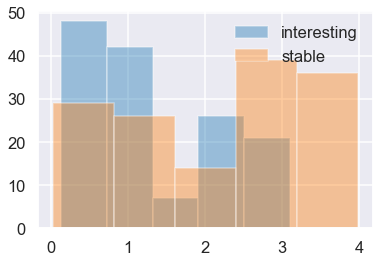

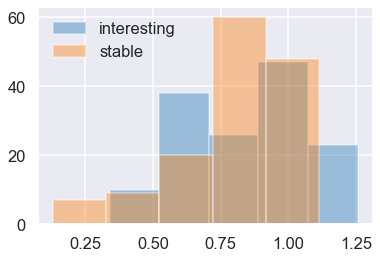

In [18]:
df_tower[df_tower['condition'] == 'interesting']['mean'].hist(bins = 5, alpha = 0.4)
df_tower[df_tower['condition'] == 'stable']['mean'].hist(bins = 5, alpha = 0.4)
plt.legend(['interesting', 'stable'])
plt.show()


df_tower[df_tower['condition'] == 'interesting']['std'].hist(bins = 5, alpha = 0.4)
df_tower[df_tower['condition'] == 'stable']['std'].hist(bins = 5, alpha = 0.4)
plt.legend(['interesting', 'stable'])
plt.show()

## Distributions of Interesting and Stable
Calculate average for each tower along each variable


In [19]:
tower_interesting = df_tower[df_tower.condition == 'interesting'].sort_values(by = 'mean', ascending = False)
df_interesting = df[df.condition == 'interesting'][['towerID','condition', 'button_pressed']]

tower_stable = df_tower[df_tower.condition == 'stable'].sort_values(by = 'mean', ascending = False)
df_stable = df[df.condition == 'stable'][['towerID','condition', 'button_pressed']]

#concatenated = pd.concat([tower_interesting.assign(dataset='avg'), df_interesting.assign(dataset='rating')])


## X-axis each tower ordered in descending interesting/stability
point for each tower and larger point for average
add call outs for specific towers


[]

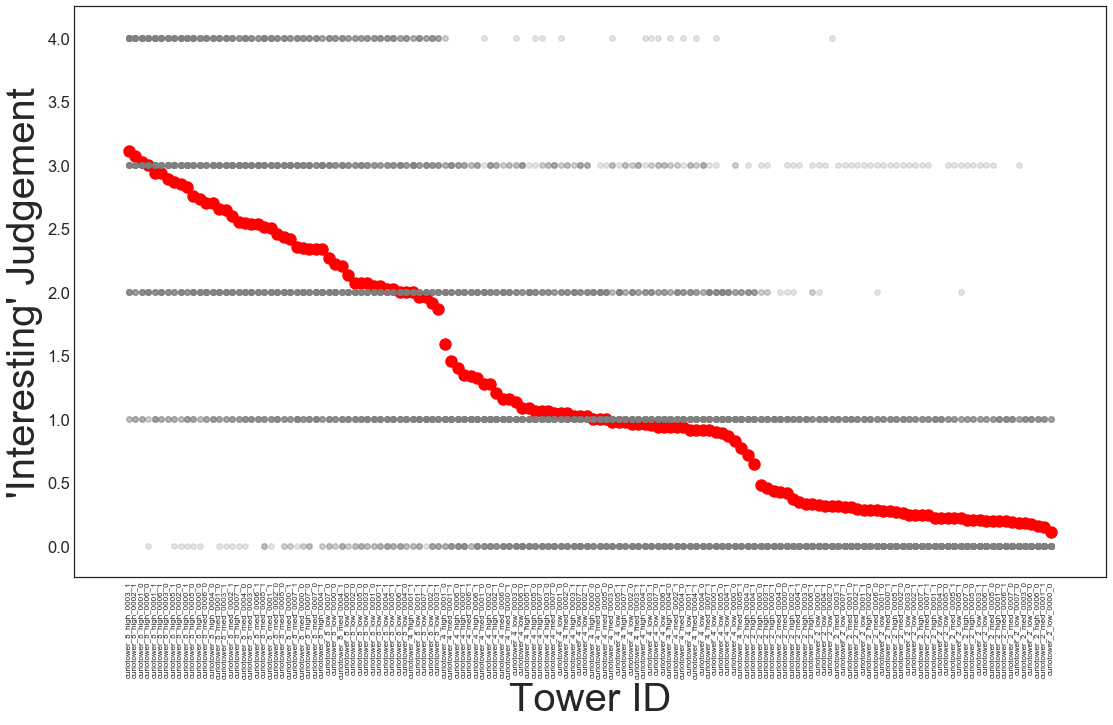

In [157]:
plt.style.use('seaborn-white')

fig, ax = plt.subplots()

ax.scatter(x=tower_interesting["towerID"], y=tower_interesting["mean"], c='red', s=120)
ax.scatter(x=df_interesting["towerID"], y=df_interesting["button_pressed"], c='grey', s=30, alpha = 0.2)


plt.xticks(rotation = 90, size = 8)
plt.ylabel("'Interesting' Judgement", size = 40)
plt.xlabel('Tower ID',size = 40)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot()

[]

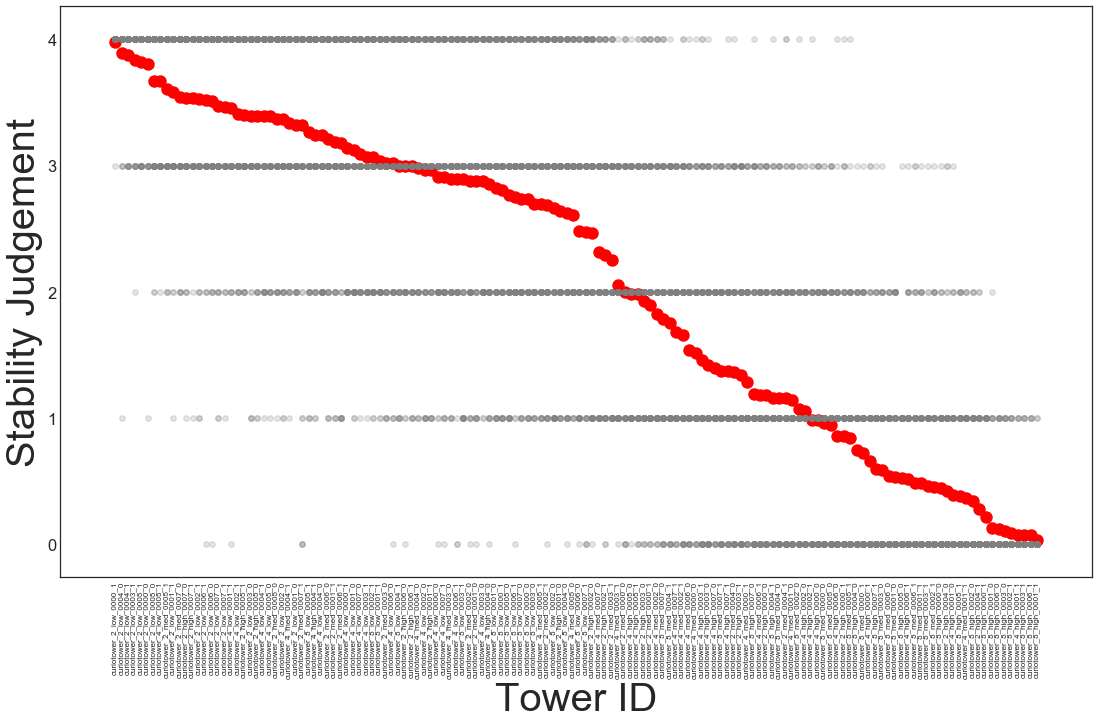

In [158]:
plt.style.use('seaborn-white')

fig, ax = plt.subplots()

ax.scatter(x=tower_stable["towerID"], y=tower_stable["mean"], c='red', s=120)
ax.scatter(x=df_stable["towerID"], y=df_stable["button_pressed"], c='grey', s=30, alpha = 0.2)


plt.xticks(rotation = 90, size = 8)
plt.ylabel("Stability Judgement", size = 40)
plt.xlabel('Tower ID',size = 40)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot()

## Correlation between interesting and stable for each tower

                    towerID  condition_x    mean_x     std_x  size_x  \
0  curiotower_2_high_0000_0  interesting  0.478261  0.690865      46   
1  curiotower_2_high_0000_1  interesting  0.434783  0.501206      46   
2  curiotower_2_high_0001_0  interesting  0.195652  0.401085      46   
3  curiotower_2_high_0001_1  interesting  0.222222  0.420437      45   
4  curiotower_2_high_0002_0  interesting  0.282609  0.583592      46   

  condition_y    mean_y     std_y  size_y  
0      stable  1.178571  0.955504      56  
1      stable  0.857143  0.961600      56  
2      stable  2.642857  0.923010      56  
3      stable  2.964286  0.873120      56  
4      stable  2.464286  1.078118      56  
-0.679322417720393


Text(0, 0.5, 'Interestingness')

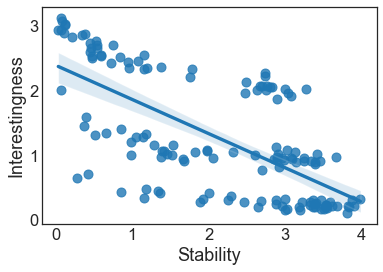

In [160]:
df_tower_interesting = df_tower[df_tower.condition == 'interesting']
df_tower_stable = df_tower[df_tower.condition == 'stable']
df_corr =pd.merge(df_tower_interesting, df_tower_stable, on = 'towerID')
print(df_corr.head())


print(df_corr['mean_x'].corr(df_corr['mean_y']))
plt.style.use('seaborn-white')

sns.regplot(data = df_corr, x ='mean_y', y = 'mean_x')
plt.xlabel('Stability')
plt.ylabel("Interestingness")

## LME models for predicting interesting
##### I prefer to use R for this...


In [107]:
#!pip install rpy2
%R library(lme4)
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

from rpy2.robjects.conversion import localconverter

In [112]:
df_int = df[df['condition'] == 'interesting'][['towerID','button_pressed', 'prolificID','num_blocks','stability']]
# Load in python library to use R 

with localconverter(ro.default_converter + pandas2ri.converter):
    r_int = ro.conversion.py2rpy(df_int)

r_int

towerID,button_pressed,prolificID,num_blocks,stability
...,...,...,...,...


In [113]:
base = importr('base')

with localconverter(ro.default_converter + pandas2ri.converter):
    df_summary = base.summary(df_int)
print(df_summary)

/Users/choldawa/opt/anaconda3/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '


   towerID          button_pressed   prolificID          num_blocks   
 Length:6575        Min.   :0.000   Length:6575        Min.   :2.000  
 Class :character   1st Qu.:0.000   Class :character   1st Qu.:2.000  
 Mode  :character   Median :1.000   Mode  :character   Median :4.000  
                    Mean   :1.267                      Mean   :4.663  
                    3rd Qu.:2.000                      3rd Qu.:8.000  
                    Max.   :4.000                      Max.   :8.000  
  stability        
 Length:6575       
 Class :character  
 Mode  :character  
                   
                   
                   



In [121]:
%%R
%R lmer('button_pressed ~ num_blocks', data=r_int)

RParsingError: Parsing status not OK - PARSING_STATUS.PARSE_ERROR

### Inspect timing data

In [64]:
df['time_on_trial'] = (df['endTrialTime'] - df['startTrialTime'])/1000
df_time = df.groupby(['gameID'])['time_on_trial'].mean()
df_time


gameID
1499-d1f6c683-8517-4d78-a880-26256f5e4a72     5.184764
2070-e571994c-0a4a-4817-a636-8ae216203c94     1.932583
2286-36094b34-2698-42ab-b05c-4274d5a5b0d0     0.971125
3381-8354e837-e1c4-4e75-a3ce-786448ac86d6    11.963681
3428-8a8ea934-86f1-492b-8777-228ac9e6e0b7     3.697819
4575-b24ebf3b-4737-4392-8228-56c27771cc1c     2.669000
5894-9b9eb6a9-b287-4d33-ace8-59351cbc5399     1.929028
6935-2e9e518a-a2d8-46e3-8353-1dc1bfd97417     2.228208
7655-1b56826c-9052-4edd-b973-65f5f01f2d34    11.077486
7681-083bb1f3-59f9-42e7-9ec9-000a9de5f6a6     6.164444
7772-a010c5df-215c-4530-86e1-fe391b4a078d     0.591000
7778-3ace1d67-b43e-4a06-a75c-1bf311297a60     3.334056
surveyData                                         NaN
Name: time_on_trial, dtype: float64

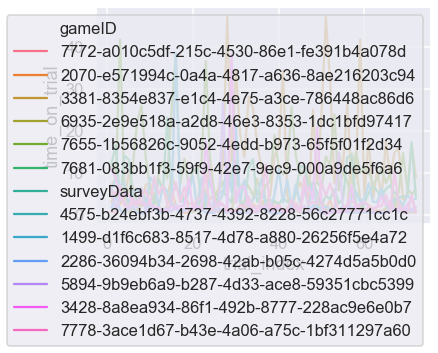

In [65]:
import seaborn as sns
sns.lineplot(data=df, x="trial_index", y="time_on_trial", hue="gameID")